# Example tracking workflow

## Comments
- This implementation of Munkres has a flag for assignments that can't be made (DISALLOWED).  Some implementations don't have this, so you can make the assignment unlikely by setting it to inf, but after assignment, you'll still need to check this assignment hasn't been made.

## Ideas
- Cover both Munkres (dense cost matrix) and JV LAPMOD (sparse cost matrix) for linking, comparing speed and memory allocation for different number of points.  This may be one for the talk, rather than having others do it.  That way it doesn't matter what memory is available.
- Start by getting a basic (adjacent frames only, no track splitting/merging) workflow working, then start add in components


## Installing packages

In [ ]:
!pip install --user matplotlib
!pip install --user pandas
!pip install --user Pillow
!pip install --user scikit-image

## Importing libraries

In [1]:
import math
import sys
import time
import util

import numpy as np

from scipy.optimize import linear_sum_assignment

## Getting coordinates present in frame

In [2]:
def get_coordinates(coords, frame):
    # Identifying rows of "coords" with current frame number
    rows = coords.index[coords['T'] == frame]

    return rows

## Initialise first timepoint
All cells detected in the first timepoint can be considered "new" tracks.  As such, we give them each a unique track ID number.

In [3]:
def initialise_first_timepoint(coords):
    # Adding a blank extra column for the track ID
    coords['TRACK_ID'] = 0

    # Getting the row indices for the first frame
    idx_first = coords['T'] == 0

    coords.loc[idx_first,'TRACK_ID'] = range(1,sum(idx_first)+1)

## Calculate linking costs

In [4]:
def calculate_dense_cost_matrix(coords,prev_rows,curr_rows,thresh):
    # Creating the empty array
    costs = np.empty((len(prev_rows),len(curr_rows)))
        
    # Iterating over each pair, calculating the cost
    for prev_i, prev_row in enumerate(prev_rows):
        for curr_i,curr_row in enumerate(curr_rows):            
            cost = calculate_cost(coords,prev_row,curr_row,thresh)
            costs[prev_i,curr_i] = cost
           
    return costs
    
def calculate_cost(coords,prev_row,curr_row,thresh):
    # Spatial linking (distance between two points)
    dx = coords['X'][curr_row] - coords['X'][prev_row]
    dy = coords['Y'][curr_row] - coords['Y'][prev_row]
    d = math.sqrt(dx*dx + dy*dy)
    
    # If the two points are separated by more than the linking threshold, set them to infinity ('inf')
    if d > thresh:
        d = 1000000000
    
    return d

# Inheriting track IDs from previous frame
If the linked point in the previous frame already has an ID assigned to it, pass this on to the linked point (this SHOULD always be the case).  If our point wasn't assigned a link, set its track ID to the smallest unused value.

In [47]:
def assign_IDs(costs, assignments, coords, prev_rows, curr_rows):
    for prev_ass, curr_ass in zip(assignments[0],assignments[1]):
        if costs[prev_ass,curr_ass] < 1000000000:
            ID = coords.at[prev_rows[prev_ass],'TRACK_ID']
            coords.at[curr_rows[curr_ass],'TRACK_ID'] = ID


# Assigning track IDs to unlinked points

In [48]:
def assign_new_IDs(coords, curr_rows):
    # Getting the maximum track ID present in coords
    max_ID = coords.TRACK_ID.max()
    
    # Iterating over all current points and assigning the next available ID if they're still 0
    for curr_row in curr_rows:
        if coords.at[curr_row,'TRACK_ID'] == 0:
            max_ID = max_ID + 1
            coords.at[curr_row,'TRACK_ID'] = max_ID

## Main workflow

In [49]:
%%html
<style>
.output_wrapper button.btn.btn-default,
.output_wrapper .ui-dialog-titlebar {
  display: none;
}
</style>

In [53]:
%matplotlib notebook

# Setting parameters
np.set_printoptions(precision=3,threshold=sys.maxsize)
linking_thresh = 10

# # Loading image stack
path = "..\\data\\ExampleTimeseries.tif"
images = util.load_images(path);

# Loading coordinates
path = "../data/ObjectCoordinatesNoHeader.csv"
coords = util.load_coordinates(path);

# # Getting the number of frames
n_frames = images.shape[2]

# Set new track IDs for each object in the first frame
initialise_first_timepoint(coords)

# Starting at frame 2, looping over each frame, linking pairs
print("")
for frame in range (1,n_frames):    
    sys.stdout.write("\rProcessing frame %i" % frame)
    
    # Get row labels for the previous and current frame
    prev_rows = get_coordinates(coords,frame-1)
    curr_rows = get_coordinates(coords,frame)
    
    # Calculate costs for each possible link, then use Munkres to determine assignments
    costs = calculate_dense_cost_matrix(coords,prev_rows,curr_rows,linking_thresh)    
    assignments = linear_sum_assignment(costs)
        
    # Assigning links
    assign_IDs(costs,assignments,coords,prev_rows,curr_rows)
    assign_new_IDs(coords,curr_rows)

print("Complete!")

Loading images from " ..\data\ExampleTimeseries.tif "
Loaded image shape:  (92, 700, 1100)
Reordered image shape:  (700, 1100, 92)
 
Loading coordinates from " ../data/ObjectCoordinatesNoHeader.csv "
Loaded data shape:  (8639, 6)
 

Processing frame 91

Rendering frame 92 of 92

<IPython.core.display.Javascript object>


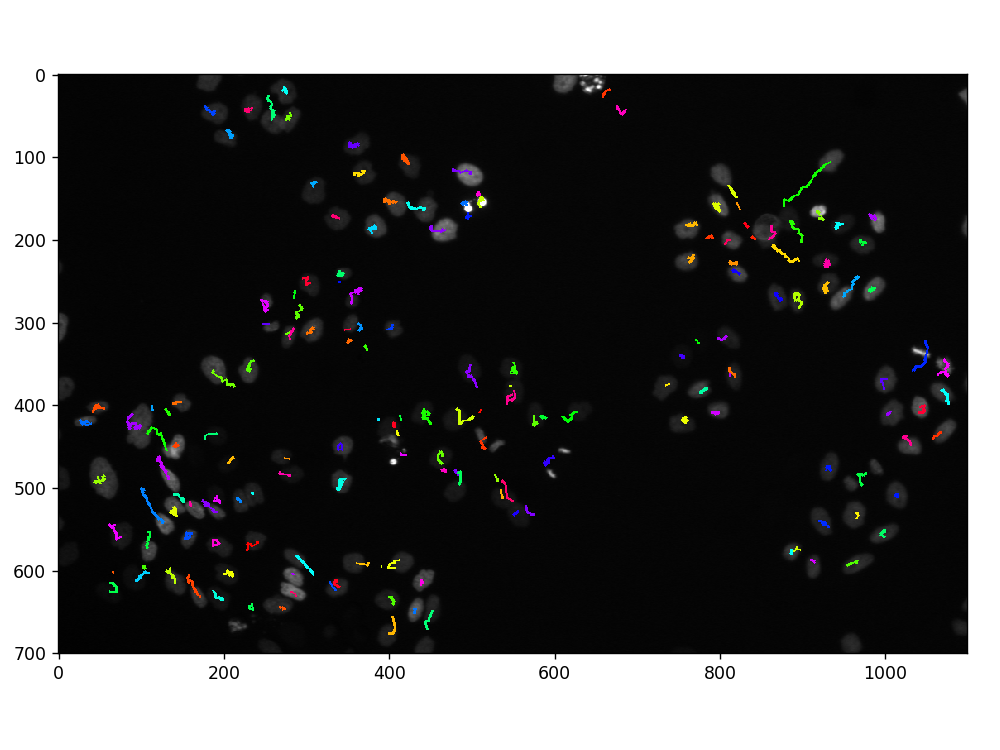

interactive(children=(IntSlider(value=0, description='frame', max=91), Output()), _dom_classes=('widget-intera…

In [54]:
# Adding track renders
util.show_overlay(images,coords)